# Towards Content-based Image Retrieval Methods

## Boilerplate for Colab 

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

In [ ]:
% cd gdrive/MyDrive

In [ ]:
! git clone https://github.com/postBG/ImageRetrieval.samsung

In [ ]:
% cd ImageRetrieval.samsung/

In [ ]:
!pip install ipython-unittest

## Let's begin! 

In [ ]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
%load_ext ipython_unittest

In [ ]:
import os, sys
import matplotlib.pyplot as plt
import unittest
import numpy as np
import utils
import torch
import torch.nn.functional as F
import torch.nn as nn
from tqdm.notebook import tqdm
from torchvision import datasets, transforms
from utils import ImageHelper

## Dataset: fashionMNIST

### Create Dataset

In [ ]:
img_size = 32
mean = (0.5,)
std = (0.5,)

# Define a transform to normalize the data
transform = transforms.Compose([transforms.Resize((img_size, img_size)), 
                                transforms.ToTensor(),
                                transforms.Normalize(mean=mean, std=std)])
image_helper = ImageHelper(mean, std)

In [ ]:
from datasets import FashionMNIST

batch_size = 256

trainset = FashionMNIST('./data', download=True, split='train', transform=transform)
valset = FashionMNIST('./data', download=True, split='val', transform=transform)
testset = FashionMNIST('./data', download=True, split='test', transform=transform)

idx_to_class = trainset.idx_to_class

trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True)
valloader = torch.utils.data.DataLoader(valset, batch_size=batch_size, shuffle=False)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=False)

### Take a Look

In [ ]:
print(trainset.classes)
print(idx_to_class)
print(f'train dataset size: {len(trainset)}')
print(f'validation dataset size: {len(valset)}')
print(f'test dataset size: {len(testset)}')

In [ ]:
img, label, idx = trainset[3]
image_helper.show_img(img)
print(f'label: {trainset.idx_to_class[label]}')

## Database & kNN Retrieval

In [ ]:
class Database(object):
    def __init__(self, dataloader, feature_extractor):
        self.dataloader = dataloader
        self.dataset = dataloader.dataset
        self.feature_extractor = feature_extractor
        self.images_indices, self.extracted_features, self.targets = self.extract_features_to_construct_database()

    @torch.no_grad()
    def extract_features_to_construct_database(self):
        self.feature_extractor.eval()
        all_indices = []
        all_features = []
        all_targets = []
        for xs, ys, idxs in tqdm(self.dataloader):
            features = self.feature_extractor(xs)
            features = features.view(features.size(0), -1)
            all_features.extend(features)
            
            all_indices.extend(idxs)
            all_targets.extend(ys)
        return torch.stack(all_indices), torch.stack(all_features), torch.stack(all_targets)
    
    def get_image_and_target(self, idx):
        return self.dataset[idx]

### Practice 1: Implement k-nearest neighbor algorithm

We will use the dot-product between two vectors as the distance.

In [ ]:
def kNN_search(query: torch.Tensor, database: Database, k=10):
    # query: batch_size * feature_size
    # database.extracted_features: database_size * feature_size
    distance_matrix = ?  # distance_matrix's shape should be batch_size * database_size
    top_scores, most_similar_indices = distance_matrix.topk(k)
    return top_scores, most_similar_indices

In [ ]:
%%unittest_main
from vector_search import kNN_search as solution_kNN_search

def generate_random_tensor(rng, size):
    return torch.tensor(rng.random(size=size))

class DummyDatabase(object):
    def __init__(self, database_size, feature_size):
        rng = np.random.default_rng(10)
        self.extracted_features = generate_random_tensor(rng, size=(database_size, feature_size))

class TestkNN(unittest.TestCase):
    def setUp(self):
        self.batch_size = 5
        self.feature_size = 32
        self.database_size = 128
        self.dummy_database = DummyDatabase(self.database_size, self.feature_size)
    
    def test_kNN_search_k10(self):
        random_seed = 0
        rng = np.random.default_rng(random_seed)
        queries = generate_random_tensor(rng, size=(self.batch_size, self.feature_size))
        top_scores, retrieved_indices = kNN_search(queries, self.dummy_database, k=10)
        
        sol_top_scores, sol_retrieved_indices = solution_kNN_search(queries, self.dummy_database, k=10)
        print(retrieved_indices.size())
        self.assertTrue(top_scores.equal(sol_top_scores))
        self.assertTrue(retrieved_indices.equal(sol_retrieved_indices))
        
    def test_kNN_search_k5(self):
        random_seed = 1
        rng = np.random.default_rng(random_seed)
        queries = generate_random_tensor(rng, size=(self.batch_size, self.feature_size))
        top_scores, retrieved_indices = kNN_search(queries, self.dummy_database, k=5)
        
        sol_top_scores, sol_retrieved_indices = solution_kNN_search(queries, self.dummy_database, k=5)
        print(retrieved_indices.size())
        self.assertTrue(top_scores.equal(sol_top_scores))
        self.assertTrue(retrieved_indices.equal(sol_retrieved_indices))

### Practice 2: Implement a Simple Flatter

In [ ]:
class SimpleFlatter(nn.Module):
    def forward(self, x):
        # x: batch_size * num_channel * img_size * img_size
        batch_size = ?
        flatten = ?  # flatten's shape should be batch_size * (num_channel * img_size * img_size)
        return flatten
    
    def eval(self):
        pass

In [ ]:
%%unittest_main
from models import SimpleFlatter as SimpleFlatterSolution


class TestSimpleFlatter(unittest.TestCase):
    def setUp(self):
        self.batch_size = 5
        self.num_channel = 3  # RGB
        self.img_size = 32
    
    def test_simple_flatter(self):
        random_seed = 0
        rng = np.random.default_rng(random_seed)
        x = generate_random_tensor(rng, size=(self.batch_size, self.num_channel, self.img_size, self.img_size))
        model = SimpleFlatter()
        out = model(x)
        
        self.assertTupleEqual((self.batch_size, self.num_channel * self.img_size * self.img_size), out.size())
        self.assertTrue(out.equal(x.view(self.batch_size, -1)))

## Your First Retrieval

### Create Your Database using Flatter and Database

In [ ]:
flatter = SimpleFlatter()
database = Database(testloader, flatter)

In [ ]:
img, target, idx = trainset[2]
print("This is you query image!")
print(f"{idx_to_class[target]}: {target}")
image_helper.show_img(img)

In [ ]:
x = img.unsqueeze(0)  # [1, channel_size, img_size, img_size]
query = flatter(x)
top_scores, indices = kNN_search(query, database)
print(f"The retrieved indices: {indices} (size: {tuple(indices.size())})")

topk = 0
retrieved_img, retrieved_label, retrieved_idx = database.get_image_and_target(indices[0][topk])
print(f"{idx_to_class[retrieved_label]}: {retrieved_label}")
image_helper.show_img(retrieved_img)

### Run All Retrieval

In [ ]:
@torch.no_grad()
def run_all_retrieval(feature_extractor, valloader, database, k=10):
    all_query_labels = []
    all_retrieved_indices = []
    all_retrieved_labels = []

    feature_extractor.eval()
    for xs, ys, idxs in tqdm(valloader):
        query_features = feature_extractor(xs)
        most_similar_indices = kNN_search(query_features, database, k=k)[1]

        all_query_labels.extend(ys)
        all_retrieved_indices.extend(most_similar_indices)
        all_retrieved_labels.extend(database.targets[most_similar_indices])

    return torch.stack(all_query_labels), torch.stack(all_retrieved_indices), torch.stack(all_retrieved_labels)

In [ ]:
query_labels, retrieved_indices, retreived_labels = run_all_retrieval(flatter, valloader, database, k=10)

## How to Evaluate An Image Retrieval System: Mean Average Precision 

<img src='./resources/map.png' width='75%'  align='left'/><br><br>

In [ ]:
def average_precision(label: int, retrieved_labels: np.array, eps=1e-12):
    corrects = np.where(retrieved_labels == label, 1, 0)
    cum_corrects = np.cumsum(corrects)
    denominators = np.arange(1, len(corrects) + 1)
    precisions = cum_corrects / denominators
    average_prevision = np.sum(precisions * corrects) / (np.sum(corrects) + eps)
    return average_prevision

### Practice 3: Implement Your Own MAP

In [ ]:
def mean_average_precision(labels, retrieved_labels):
    labels, retrieved_labels = labels.cpu().numpy(), retrieved_labels.cpu().numpy()
    aps = ?
    aps = np.array(aps)
    return np.mean(aps)

In [ ]:
%%unittest_main
from metrics import mean_average_precision as solution_map

def generate_random_integer_tensor(rng, size, low=0, high=10):
    return torch.tensor(rng.integers(low=low, high=high, size=size))

class TestmAP(unittest.TestCase):
    def setUp(self):
        self.batch_size = 5
        self.num_classes = 10
        
    def test_mAP(self):
        random_seed = 0
        rng = np.random.default_rng(random_seed)
        k = 10
        
        labels = generate_random_integer_tensor(rng, size=self.batch_size, high=self.num_classes)
        retrieved_lables = generate_random_integer_tensor(rng, size=(self.batch_size, k), high=self.num_classes)
        mean_ap = mean_average_precision(labels, retreived_labels)
        
        self.assertEqual(mean_ap, solution_map(labels, retreived_labels))

### Evaluate Simple Flatter

In [ ]:
s_map = mean_average_precision(query_labels, retreived_labels)
print(f"Simple Flatter's mAP: {s_map}")

### Improve Simple Flatter: Normalization

In [ ]:
class NormalizedSimpleFlatter(nn.Module):
    def forward(self, x):
        # x: batch_size * num_channel * img_size * img_size
        batch_size = x.size(0)
        flatten = x.view(batch_size, -1)  # flatten's shape should be batch_size * (num_channel * img_size * img_size)
        return F.normalize(flatten)
    
    def eval(self):
        pass
    
normed_flatter = NormalizedSimpleFlatter()

In [ ]:
normed_database = Database(testloader, normed_flatter)

In [ ]:
query_labels2, retrieved_indices2, retreived_labels2 = run_all_retrieval(normed_flatter, valloader, normed_database, k=10)
print(f"Normalized Flatter's mAP: {mean_average_precision(query_labels2, retreived_labels2)}")

## Deep Learning Based Image Retrieval

In [ ]:
from models import FeatureExtractor, Classifier
from torch.optim import Adam

feature_extractor = FeatureExtractor()
classifier = Classifier()
model = nn.Sequential(feature_extractor, classifier)

optimizer = Adam(model.parameters(), lr=0.001)

In [ ]:
from trainers import train

epoch = 10
model = train(model, optimizer, trainloader, valloader, epoch)

In [ ]:
deep_database = Database(testloader, feature_extractor)

query_labels3, retrieved_indices3, retreived_labels3 = run_all_retrieval(feature_extractor, valloader, deep_database, k=10)
deep_map = mean_average_precision(query_labels3, retreived_labels3)
print(f"Deep Feature Extractor's mAP: {deep_map}")

## Compare the Image Retrieval Systems

In [ ]:
print(f'Flatters database size: {database.extracted_features.numel()}')
print(f'Deep database size: {deep_database.extracted_features.numel()}')
print()
print(f'The deep learning based system is {int(database.extracted_features.numel() / deep_database.extracted_features.numel())}x smaller,')
print("while it's mAP is {:.2f}% better even on this simple dataset.".format((deep_map - s_map) / s_map * 100))

## Rotated Dataset?

In [ ]:
from rotations import RotationPredDataset
rotated_testset = RotationPredDataset(testset)

In [ ]:
img, rot_label, idx = rotated_testset[124]
image_helper.show_img(img)

### Practice (If time allows)

Use the trained model above (`feature_extractor`) to run retrieval on `rotated_testset`.

**Steps to implement**:
1. Create a `DataLoader` with `rotated_testset`
2. Create a `Database`
3. Run retrieval using the `feature_extractor`, `valloader`, and Database created in step 2 (use k=10).
4. Calculate mAP score of step 3
5. Print the mAP score!

In [ ]:
rotated_testloader = ?
rotated_database = ?

query_labels4, retrieved_indices4, retreived_labels4 = ?
deep_map = ?
print(f"Deep Feature Extractor's mAP: {deep_map}")

### How are the results?

You may notice that the mAP is terrible (~0.11 for me), despite using a deep neural network.

## Self-supervision: Pretext tasks

### Rotation prediction
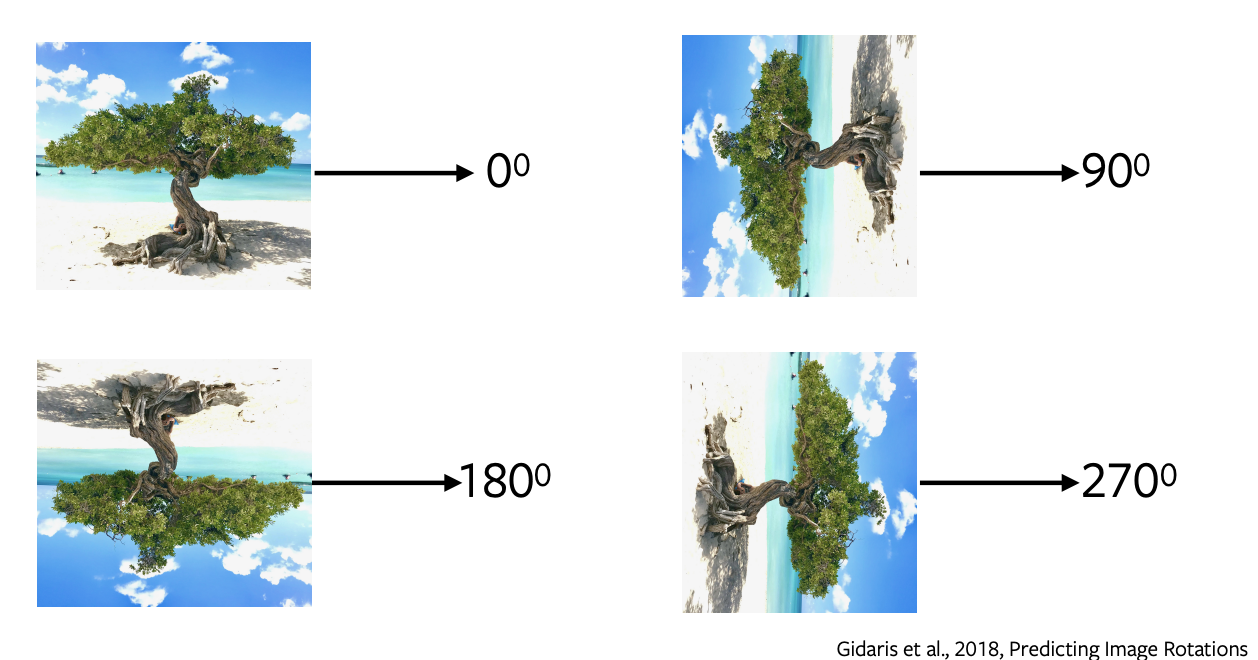

### Colorization
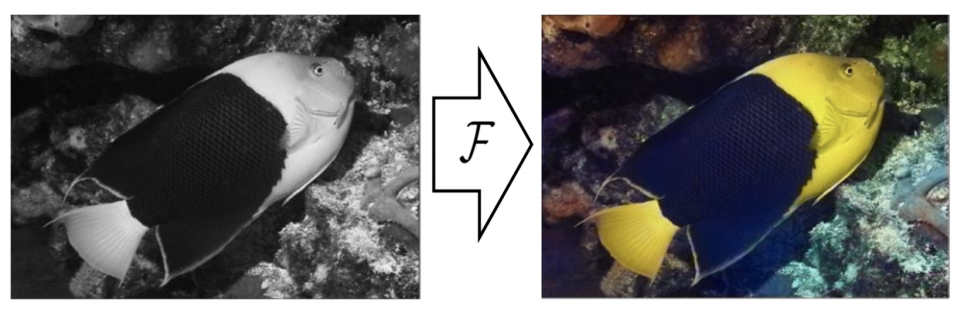

### Jigsaw
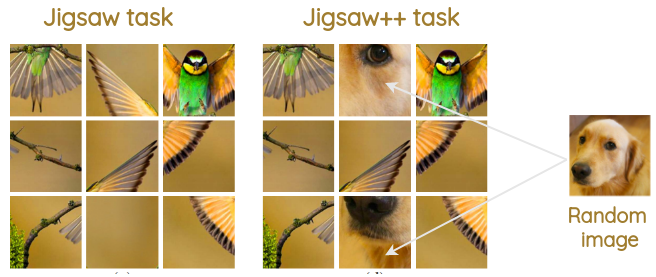